<div class="alert alert-info">
    
Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
    
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install imblearn

     |████████████████████████████████| 226 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 47.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
!pip install category_encoders

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

from seaborn import boxplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from category_encoders.one_hot import OneHotEncoder

from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostClassifier

pd.options.display.float_format = '{:.2f}'.format

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [5]:
def quer(tab):
    return f'''
            SELECT *
            FROM {tab}
            LIMIT 1;
            '''

In [6]:
for tab in ['case_ids', 'vehicles', 'collisions', 'parties']:
    sample_df = pd.read_sql_query(quer(tab), con=engine).columns
    print(sample_df)
    print(len(sample_df))

Index(['case_id', 'db_year'], dtype='object')
2
Index(['id', 'case_id', 'party_number', 'vehicle_type', 'vehicle_transmission',
       'vehicle_age'],
      dtype='object')
6
Index(['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time'],
      dtype='object')
20
Index(['id', 'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use'],
      dtype='object')
9


Колонки на месте, ключ case_id также

##  Проведите статистический анализ факторов ДТП

In [7]:
query = '''
SELECT DATE_TRUNC('year', COLLISION_DATE)::date, 
       COUNT(*)
FROM collisions 
GROUP BY DATE_TRUNC('year', COLLISION_DATE)
'''

sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,date_trunc,count
0,2009-01-01,426228
1,2010-01-01,416490
2,2011-01-01,402428
3,2012-01-01,154547
4,2013-01-01,305
5,2020-01-01,2


<AxesSubplot:ylabel='date_trunc'>

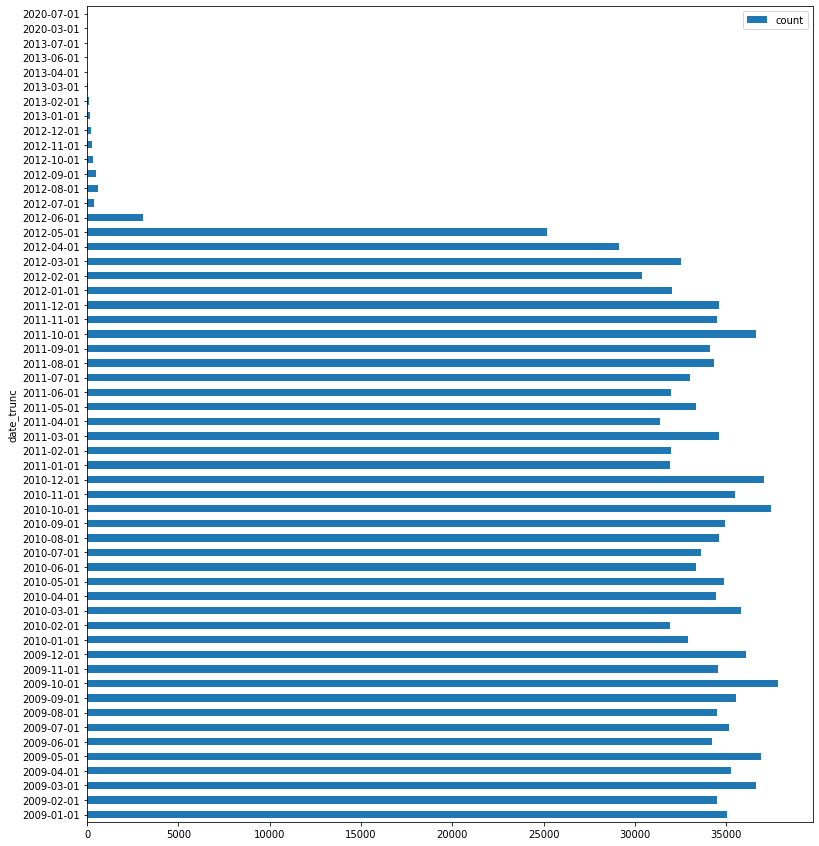

In [8]:
query = '''
SELECT DATE_TRUNC('month', COLLISION_DATE)::date, 
       COUNT(*)
FROM collisions 
GROUP BY DATE_TRUNC('month', COLLISION_DATE)
'''

sample_df = pd.read_sql_query(query, con=engine) 
sample_df.plot.barh(x='date_trunc', y='count', figsize=(13, 15))

Имеется резкое падение с июня 2016 года и далее, наверное, статистика за этот период времени надлежащим образом не сформирована. С августа 2013 по февраля 2020 (включительно) данных вообще нет.

### Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы. 

Задачи для коллег:
1.	Установить среднее количество ДТП в зависимости от погодных условий.
2.	Установить количество ДТП происходящее на перекрестках.
3.	Установить количество ДТП происходящее в темное время суток.
4.	Установить среднее количество ДТП в зависимости от сезона.
5.	Проанализировать тип участника происшествия в зависимости от погодных условий:
    -	объединить таблицы parties и vehicles по CASE_ID, сгруппировать данные по столбце WEATHER_1 и PARTY_TYPEl;
    -	постройте круговые диаграммы для каждого вида погоды, чтобы оценить при какой погоде как часто встречаются различные тип участников происшествия;
    -	проанализируете данные, сделайте вывод.
6.	Проанализировать серьезность происшествия в зависимости от возраста автомобиля:
    -	объединить таблицы collisions и vehicles по CASE_ID, VEHICLE_AGE разделить на промежутки, сгруппировать данные по полученным промежуткам и COLLISION_DAMAGE
    -	постройте круговые диаграммы для каждой категории возраста;
    -	проанализируете данные, сделайте вывод.


In [9]:
query = '''
SELECT WEATHER_1, 
       PARTY_TYPE,
       COUNT(PARTY_TYPE)
FROM parties AS p
LEFT JOIN collisions c ON p.case_id = c.case_id
GROUP BY WEATHER_1, PARTY_TYPE
ORDER BY weather_1, COUNT(PARTY_TYPE) DESC 
'''

df = pd.read_sql_query(query, con=engine) 

In [10]:
def autopct(pct): 
    return ('%.2f' % pct) if pct > 1 else ''

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


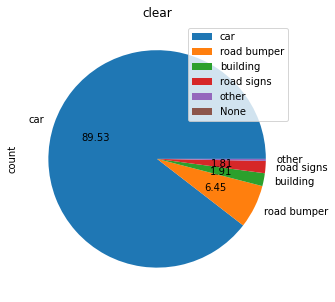

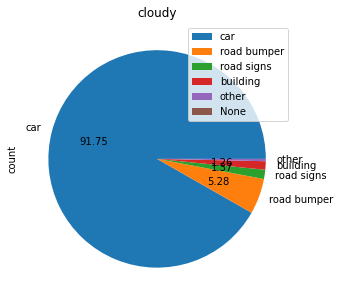

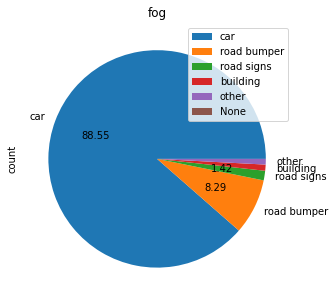

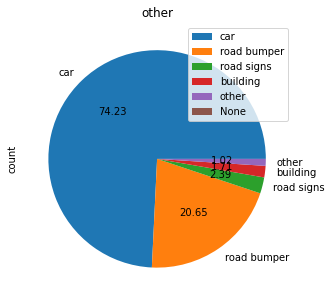

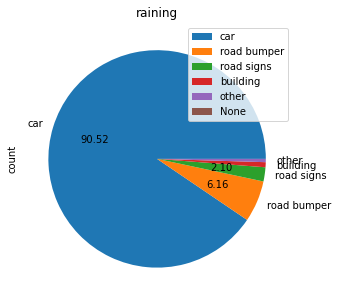

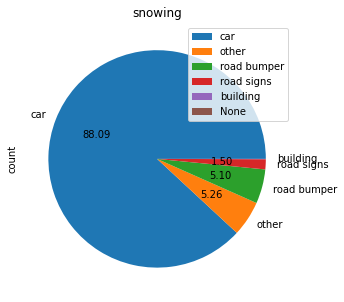

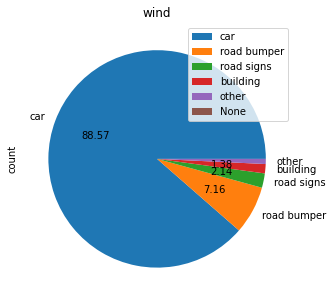

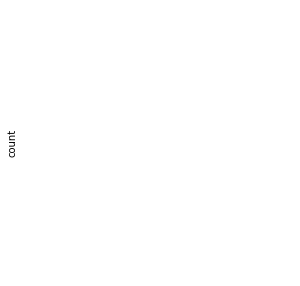

In [11]:
for weather in df['weather_1'].unique():
    df_plot = df[df.weather_1 == weather].set_index('party_type')
    
    ax = df_plot.plot.pie(y='count', figsize=(5, 5), autopct=autopct)
    ax.set_title(weather)

<div class="alert alert-info">
Изходя из вышеизложенных данных машины составляют абсолютнеое большинство при ДТП вне зависемости от погодных условий, однако при облачной и дождливой погоде их число возрастает до 88 и 90 процентов соответсвтенно. 

In [12]:
query = '''
WITH tab AS (
SELECT COLLISION_DAMAGE, 
       CASE 
           WHEN VEHICLE_AGE <= 5 THEN 1
           WHEN VEHICLE_AGE > 5 AND VEHICLE_AGE <= 10 THEN 2
           WHEN VEHICLE_AGE > 10 AND VEHICLE_AGE <= 20 THEN 3
           WHEN VEHICLE_AGE > 20 AND VEHICLE_AGE <= 30 THEN 4
           WHEN VEHICLE_AGE > 30 AND VEHICLE_AGE <= 30 THEN 5
           ELSE 6
       END AS cat_vehicle
FROM vehicles  AS v
LEFT JOIN collisions c ON v.case_id = c.case_id
)

SELECT cat_vehicle, 
       collision_damage, 
       COUNT(*)
FROM tab 
GROUP BY cat_vehicle, collision_damage
ORDER BY cat_vehicle, collision_damage
'''

df = pd.read_sql_query(query, con=engine) 

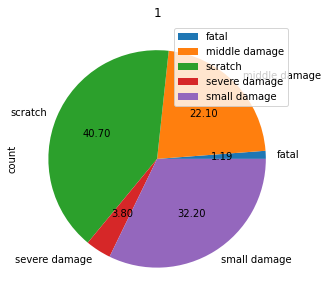

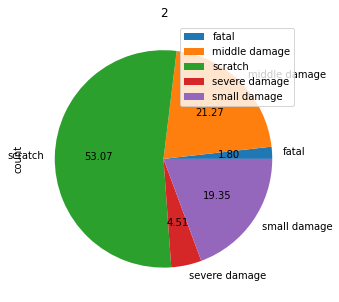

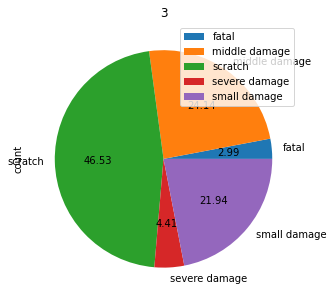

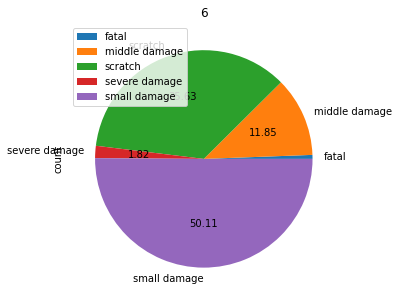

In [13]:
for i in df['cat_vehicle'].unique():
    df_plot = df[df.cat_vehicle == i].set_index('collision_damage')
    
    ax = df_plot.plot.pie(y='count', figsize=(5, 5), autopct=autopct)
    ax.set_title(i)

<div class="alert alert-info">
Возраст машины виляет неоднозначно, наибольшее различие относительно остальных групп показывают машины возраст которых 5 лет или меньше. Они получают больше небольших повреждений и меньше царапин.

## Создайте модель для оценки водительского риска

Мной взяты следующие признаки: 

- PARTY_SOBRIETY - трезвость учасника
- INTERSECTION - перекресток 
- WEATHER_1 - погода 
- ROAD_SURFACE - состояние дороги 
- LIGHTING - освещение 
- COUNTY_CITY_LOCATION - номер районов 
- LOCATION_TYPE - тип дороги 
- ROAD_CONDITION_1 - дорожное состояние 
- VEHICLE_TYPE - тип кузова 
- VEHICLE_TRANSMISSION - тип КПП 
- VEHICLE_AGE - возраст автомобиля

Все эти признаки характеризуют состояние машины, предполагаемого маршрута, состояния водителя и могут быть получены до аварии (если в автомобиле установить прибор для проверки водителя на алкоголь)

In [14]:
query = '''
SELECT PARTY_SOBRIETY,
       INTERSECTION, 
       WEATHER_1, 
       ROAD_SURFACE, 
       LIGHTING, 
       COUNTY_CITY_LOCATION, 
       LOCATION_TYPE, 
       ROAD_CONDITION_1,  
       VEHICLE_TYPE, 
       VEHICLE_TRANSMISSION,
       VEHICLE_AGE,
       at_fault
FROM collisions AS c
LEFT JOIN parties p ON c.case_id = p.case_id 
LEFT JOIN vehicles v ON c.case_id = v.case_id
WHERE DATE_PART('year', COLLISION_DATE) = 2012
      AND PARTY_TYPE = 'car'
      AND COLLISION_DAMAGE != 'scratch'
'''

df = pd.read_sql_query(query, con=engine) 

In [15]:
df.shape

(226984, 12)

<div class="alert alert-info">
    
Согласно задания я должен: 'Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)'.

А для того чтобы выбрать тип виновника только машина я должен наверно выбрать учасника car и выставить at_fault = 1, но тогда что у меня будет таргетом для модели машинного обучения? 

В таблице есть другой столбец MOTOR_VEHICLE_INVOLVED_WITH (дополнительные участники ДТП) и там указываются другие участники, поэтому в данных, полученных по моему запросу, учасниками ДТП являются не только машины.
    
И я так понимаю - это БД общая, то есть ее создавала не компания под свои нужды, а вел какой-то публичный орган власти. Потому что зачем компании, которая занимается предоставлением в аренду машин информация об авариях без участия машин? 
    
И для того чтобы сделать более глубокий анализ о причинах аварийности автомобилей мы делаем выборку с участием автомобилей. 
    
И опять таки я не могу понять как мы будем строить модель машинного обучения для предсказания виновника дтп, если в выборке виновник дтп это только машина? 

In [16]:
df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

location_type          55.19
vehicle_age            49.32
vehicle_transmission   48.65
vehicle_type           47.83
party_sobriety          1.77
road_surface            0.66
road_condition_1        0.58
intersection            0.48
lighting                0.36
weather_1               0.34
county_city_location    0.00
at_fault                0.00
dtype: float64

У половины автомобилей возраст не известен, так как данных пропуски с этой колонкой лучше удалить.

<div class="alert alert-info">
У половины автомобилей возраст не известен, заменим их на медианое значение.

In [17]:
df['vehicle_age'].fillna(df['vehicle_age'].mean(), inplace=True)

In [18]:
df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

location_type          55.19
vehicle_transmission   48.65
vehicle_type           47.83
party_sobriety          1.77
road_surface            0.66
road_condition_1        0.58
intersection            0.48
lighting                0.36
weather_1               0.34
county_city_location    0.00
vehicle_age             0.00
at_fault                0.00
dtype: float64

Остались незначительные пропуски, кроме location_type, vehicle_transmission, vehicle_type - здесь просто заполним unknow

In [19]:
di = {'location_type':'unknow', 'vehicle_transmission':'unknow', 'vehicle_type':'unknow'}
df.fillna(value=di, inplace=True)

In [20]:
df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

party_sobriety         1.77
road_surface           0.66
road_condition_1       0.58
intersection           0.48
lighting               0.36
weather_1              0.34
county_city_location   0.00
location_type          0.00
vehicle_type           0.00
vehicle_transmission   0.00
vehicle_age            0.00
at_fault               0.00
dtype: float64

In [21]:
df.dropna(inplace=True)

In [22]:
df.shape

(218951, 12)

<div class="alert alert-info">
Заполнил большинство пропусков при помощи медианного значения и unknow

In [23]:
df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

party_sobriety         0.00
intersection           0.00
weather_1              0.00
road_surface           0.00
lighting               0.00
county_city_location   0.00
location_type          0.00
road_condition_1       0.00
vehicle_type           0.00
vehicle_transmission   0.00
vehicle_age            0.00
at_fault               0.00
dtype: float64

In [24]:
df.dtypes

party_sobriety           object
intersection            float64
weather_1                object
road_surface             object
lighting                 object
county_city_location     object
location_type            object
road_condition_1         object
vehicle_type             object
vehicle_transmission     object
vehicle_age             float64
at_fault                  int64
dtype: object

In [25]:
num = ['vehicle_age']
cat = list(set(df.columns) - set(num))

In [26]:
cat

['weather_1',
 'road_surface',
 'lighting',
 'at_fault',
 'county_city_location',
 'location_type',
 'intersection',
 'road_condition_1',
 'party_sobriety',
 'vehicle_type',
 'vehicle_transmission']

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='vehicle_age'>

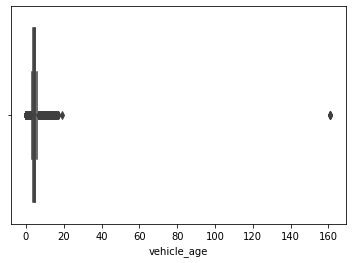

In [27]:
boxplot(df['vehicle_age'])

In [28]:
df['vehicle_age'].describe()

count   218951.00
mean         4.91
std          2.33
min          0.00
25%          4.00
50%          4.91
75%          4.91
max        161.00
Name: vehicle_age, dtype: float64

Имеется очевидный выброс по возрасту машины - 161 год. Также согласно графику выбросами являются машины возраст которых более 15 лет, однако я не считаю это выбросом, потому что в этом нет ничего необычного.

In [29]:
df = df[df['vehicle_age'] < 30]

In [30]:
df['vehicle_age'].describe()

count   218947.00
mean         4.90
std          2.24
min          0.00
25%          4.00
50%          4.91
75%          4.91
max         19.00
Name: vehicle_age, dtype: float64

In [31]:
for i in cat:
    print(df[i].unique())

['clear' 'cloudy' 'fog' 'snowing' 'raining' 'other' 'wind']
['dry' 'wet' 'snowy' 'slippery']
['daylight' 'dark with street lights' 'dark with no street lights'
 'dusk or dawn' 'dark with street lights not functioning']
[0 1]
['1932' '1942' '1900' '1915' '5400' '2400' '3905' '3801' '2700' '5000'
 '1965' '1976' '1908' '5300' '1953' '0109' '3400' '0111' '1977' '4905'
 '3313' '4402' '3713' '1955' '3010' '0700' '4400' '4313' '1959' '5800'
 '3705' '1926' '1919' '3711' '3004' '1928' '0200' '4908' '2708' '1901'
 '5601' '5604' '0704' '1941' '4807' '4114' '4303' '3300' '1938' '1992'
 '3008' '3345' '3700' '3026' '3610' '5607' '4113' '1005' '4104' '4200'
 '1925' '3607' '3706' '1922' '3605' '3015' '0710' '0106' '1902' '4900'
 '5600' '3490' '1956' '3600' '3024' '1950' '0100' '3496' '5500' '3019'
 '1500' '3002' '2200' '3105' '4000' '4117' '2802' '1960' '1905' '5102'
 '3616' '0101' '1300' '3392' '1948' '3309' '3311' '0601' '3601' '3619'
 '0900' '4006' '3302' '1000' '0701' '1001' '2706' '4700' '4214' '

С категориальными фичами все в порядке. 

In [32]:
df.duplicated().sum()

121820

In [33]:
df.drop_duplicates(inplace=True)

In [34]:
df.duplicated().sum()

0

<div class="alert alert-info">
Удалил дубликаты 

### Анализ

In [35]:
df.columns

Index(['party_sobriety', 'intersection', 'weather_1', 'road_surface',
       'lighting', 'county_city_location', 'location_type', 'road_condition_1',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age', 'at_fault'],
      dtype='object')

In [36]:
piv = pd.pivot_table(df[['party_sobriety', 'at_fault', 'county_city_location' ]], index='party_sobriety',
               columns='at_fault', aggfunc='count' )
piv

county_city_location       
at_fault                                                  0      1
party_sobriety                                                    
had been drinking, impairment unknown                   242   1145
had been drinking, not under influence                  424   1001
had been drinking, under influence                      493   7334
had not been drinking                                 38123  37051
impairment unknown                                     2465   7639
not applicable                                          600    610

In [37]:
piv.columns = [0, 1]

In [38]:
piv['percent'] = round(piv[1]*100/(piv[0] + piv[1]), 2)
piv

,0,1,percent
party_sobriety,,,
"had been drinking, impairment unknown",242,1145,82.55
"had been drinking, not under influence",424,1001,70.25
"had been drinking, under influence",493,7334,93.70
had not been drinking,38123,37051,49.29
impairment unknown,2465,7639,75.60
not applicable,600,610,50.41


Наличие опьянения серьезно увеличивает аварийность по вине водителя. Если трезвые водители признаны виновниками ДТП только в 49.29% случаев, то нетрезвые от 70.25% до 93.70% в зависимости от степени опьянения.

Считаю, что имеет смысл объединить категории нетрезвых водителей, потому что, если возникнет необходимость установки оборудования для фиксации состояния водителей - без разницы какая будет степень опьянения.

In [39]:
lis = ['had been drinking, under influence',
       'had been drinking, not under influence',
       'had been drinking, impairment unknown']
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'had been drinking' if x in lis else x)

In [40]:
df['party_sobriety'].unique()

array(['had not been drinking', 'impairment unknown', 'had been drinking',
       'not applicable'], dtype=object)

In [41]:
piv = pd.pivot_table(df[['party_sobriety', 'at_fault', 'county_city_location' ]], index='party_sobriety',
               columns='at_fault', aggfunc='count' )
piv.columns = [0, 1]
piv['percent'] = round(piv[1]*100/(piv[0] + piv[1]), 2)
piv

,0,1,percent
party_sobriety,,,
had been drinking,1159,9480,89.11
had not been drinking,38123,37051,49.29
impairment unknown,2465,7639,75.60
not applicable,600,610,50.41


In [42]:
def piv_for_fault(col, col1='county_city_location', aggfunc='count'):
    piv = pd.pivot_table(df[[col, 'at_fault', col1]], index=col,
                   columns='at_fault', aggfunc=aggfunc)
    piv.columns = [0, 1]
    piv['percent'] = round(piv[1]*100/(piv[0] + piv[1]), 2)
    return piv

In [43]:
piv_for_fault('intersection')

,0,1,percent
intersection,,,
0.00,30267,41578,57.87
1.00,12080,13202,52.22


От перекрестков вроде мало что зависит 

In [44]:
piv_for_fault('weather_1')

,0,1,percent
weather_1,,,
clear,30963,38666,55.53
cloudy,8487,11631,57.81
fog,210,353,62.70
other,48,83,63.36
raining,2476,3776,60.40
snowing,137,249,64.51
wind,26,22,45.83


Относительно хорошей погоды наибольшее влияние оказывает снегопад, но аварий при нем в абсолютных значениях мало, наверное в месте фиксации снегопад не частое явление.

In [45]:
df.columns

Index(['party_sobriety', 'intersection', 'weather_1', 'road_surface',
       'lighting', 'county_city_location', 'location_type', 'road_condition_1',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age', 'at_fault'],
      dtype='object')

In [46]:
piv_for_fault('road_surface')

,0,1,percent
road_surface,,,
dry,36435,45483,55.52
slippery,55,78,58.65
snowy,263,567,68.31
wet,5594,8652,60.73


Состояние дорожного полотна влияет на аварийность, но похоже, что дороги практически всегда сухие.

In [47]:
piv_for_fault('road_condition_1')

,0,1,percent
road_condition_1,,,
construction,1231,1387,52.98
flooded,35,75,68.18
holes,182,227,55.50
loose material,127,191,60.06
normal,40056,52018,56.50
obstruction,314,346,52.42
other,316,418,56.95
reduced width,86,118,57.84


Меньше всего аварий на разбитых и строящихся дорогах, наверное, потому что водители максимально осторожны на таких участках.

In [48]:
piv_for_fault('lighting')

,0,1,percent
lighting,,,
dark with no street lights,3757,6412,63.05
dark with street lights,9021,13149,59.31
dark with street lights not functioning,179,250,58.28
daylight,27083,32085,54.23
dusk or dawn,2307,2884,55.56


Неосвещенные улицы увеличивают аварийность.

In [49]:
piv_for_fault('vehicle_transmission')

,0,1,percent
vehicle_transmission,,,
auto,15335,17673,53.54
manual,16471,20255,55.15
unknow,10541,16852,61.52


Влияние коробки передач не очевидно.

<AxesSubplot:xlabel='vehicle_age', ylabel='Count'>

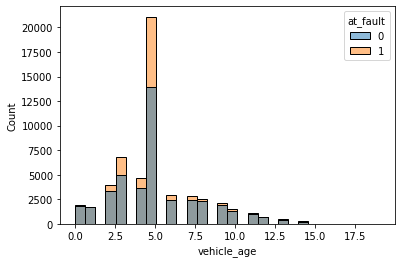

In [50]:
sns.histplot(data=df, x="vehicle_age", hue="at_fault", bins=30)

<AxesSubplot:xlabel='vehicle_age', ylabel='Count'>

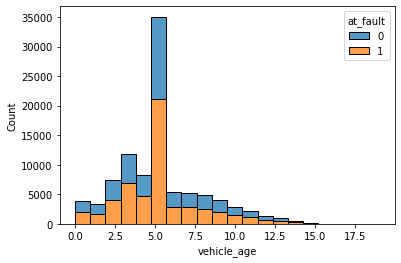

In [51]:
sns.histplot(data=df, x="vehicle_age", hue="at_fault", multiple="stack", bins=20)

In [52]:
df.loc[df.vehicle_age.isin([4, 5, 6]), 'at_fault'].value_counts()

1    11411
0     9167
Name: at_fault, dtype: int64

In [53]:
df.loc[~df.vehicle_age.isin([4, 5, 6]), 'at_fault'].value_counts()

1    43369
0    33180
Name: at_fault, dtype: int64

Влияние возраста автомобиля на аварийность не очевидно.

### Подготовка данных

In [54]:
num

['vehicle_age']

In [55]:
cat = list(set(cat) - set(['at_fault']))
cat

['weather_1',
 'road_surface',
 'lighting',
 'county_city_location',
 'location_type',
 'intersection',
 'road_condition_1',
 'party_sobriety',
 'vehicle_type',
 'vehicle_transmission']

In [56]:
y = df['at_fault']
X = df.drop('at_fault', axis=1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                               shuffle=True, random_state=4,
                               stratify=y)

In [58]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77701, 11), (19426, 11), (77701,), (19426,))

Обучим для решения проблемы модели логистической регрессии, случайного леса, катбуста. Предобработка данных будет отличатся от модели к модели.

In [59]:
numeric_transformer = Pipeline(steps=[
     ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('cat', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
     ("num_transform", numeric_transformer, num), 
    ("cat_transform", categorical_transformer, cat)], 
    remainder='drop',
)

pipeline_logist = Pipeline([('preprocessor', preprocessor), 
                            ('imb', SMOTE()),
                           ('clf', LogisticRegression(max_iter=800)),
                           ])
pipeline_logist

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder())]),
                                                  ['weather_1', 'road_surface',
                                                   'lighting',
                                                   'county_city_location',
                                                   'location_type',
                                                   'intersection',
                                                   'road_condition_1',
                                                   'party_sobriety',
                                                   'vehicle_type',
                                                   'vehicle_transmission'])])),
                ('imb', SMOTE()), ('clf', LogisticRegression(max_iter=800))])

In [60]:
y_train.value_counts()

1    43824
0    33877
Name: at_fault, dtype: int64

<div class="alert alert-info">
Есть знаимый дисбаланс классов, поэтому выше я воспользовался библиотекой imbalanced-learn

<div class="alert alert-info">
Основной метрикой выберем roc-auc, так как эта метрика учитывает все пороговые значения.

In [61]:
param = [ {"clf__penalty": ['l2', 'none'], 
           'clf__C':[1, 0.5, 0.1]}
        ]  
                                       
grid_search_linear = GridSearchCV(pipeline_logist, param, cv=5, n_jobs=-1, 
                                 refit=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'], scoring='roc_auc')
grid_search_linear.fit(X_train, y_train)
print("Лучшие параметры:")
print(grid_search_linear.best_params_)
print("Лучшая метрика на валидационных данных:")
print(grid_search_linear.best_score_)


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.9/site-

Лучшие параметры:
{'clf__C': 0.1, 'clf__penalty': 'l2'}
Лучшая метрика на валидационных данных:
0.6349710425579758


In [62]:
score_logist = grid_search_linear.best_score_

### Случайный лес 

In [63]:
numeric_transformer = Pipeline(steps=[
     ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('cat', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
     ("num_transform", numeric_transformer, num), 
    ("cat_transform", categorical_transformer, cat)], 
    remainder='drop',
)

pipeline_rforest = Pipeline([('preprocessor', preprocessor), 
                             ('imb', SMOTE()),
                             ('clf', RandomForestClassifier(max_features='sqrt'))])
pipeline_rforest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder())]),
                                                  ['weather_1', 'road_surface',
                                                   'lighting',
                                                   'county_city_location',
                                                   'location_type',
                                                   'intersection',
                                                   'road_condition_1',
                                                   'party_sobriety',
                                                   'vehicle_type',
                                                   'vehicle_transmission'])])),
                ('imb', SMOTE()), ('clf', RandomForestClassifier())])

In [64]:
param = [ {"clf__n_estimators": list(range(100, 301, 100)),
           'clf__max_depth':[10, 15]}
        ]  
                                       
grid_search_rforest = GridSearchCV(pipeline_rforest, param, cv=5, n_jobs=-1, 
                                 refit=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'], scoring='roc_auc')
grid_search_rforest.fit(X_train, y_train)
print("Лучшие параметры:") 
print(grid_search_rforest.best_params_)
print("Лучшая метрика на валидационных данных:")
print(grid_search_rforest.best_score_)


Лучшие параметры:
{'clf__max_depth': 10, 'clf__n_estimators': 200}
Лучшая метрика на валидационных данных:
0.631944657838053


In [65]:
score_forest = grid_search_rforest.best_score_

<div class="alert alert-info">
Выберем roc-auc, так как эта метрика учитывает все пороговые значения

### Catboost

In [66]:
X_train.dtypes

party_sobriety           object
intersection            float64
weather_1                object
road_surface             object
lighting                 object
county_city_location     object
location_type            object
road_condition_1         object
vehicle_type             object
vehicle_transmission     object
vehicle_age             float64
dtype: object

In [67]:
X_train[cat] = X_train[cat].astype('str')

In [68]:
model = CatBoostClassifier(iterations=3000, 
                          cat_features=cat,
                          verbose=False, 
                          eval_metric ='AUC'
                         )
param = {'l2_leaf_reg':[0.5, 1], 
        'depth':[6, 8], 
         'learning_rate':[0.03, 0.003]
       }

grid_search = model.grid_search(param,
                                X=X_train,
                                y=y_train,
                                train_size=0.8,
                                refit=True,
                                cv=5,
                                calc_cv_statistics=True,
                                verbose=True,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7580642819
bestIteration = 2993

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7580643	best: 0.7580643 (0)	total: 6m 6s	remaining: 42m 47s

bestTest = 0.7363299515
bestIteration = 2999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7363300	best: 0.7580643 (0)	total: 11m 44s	remaining: 35m 13s

bestTest = 0.7569913389
bestIteration = 2936

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.7569913	best: 0.7580643 (0)	total: 17m 52s	remaining: 29m 48s

bestTest = 0.7358524699
bestIteration = 2999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.7358525	best: 0.7580643 (0)	total: 23m 30s	remai

In [69]:
scores = pd.DataFrame({'model': ['logist', 'forest', 'catbossts'],
                       'score':[score_logist, score_forest, 0.757]})

In [70]:
scores

,model,score
0,logist,0.63
1,forest,0.63
2,catbossts,0.76


<div class="alert alert-info">
Лучший результат показывает катбуст поэтому будем работать с ним

Лучшей моделью на вариационных данных оказался случайный лес, поэтому будем работать с ним.

In [71]:
X_test[cat] = X_test[cat].astype('str')

In [72]:
pred = model.predict(X_test)

In [73]:
print('roc_auc', roc_auc_score(y_test, pred))
print('f1', f1_score(y_test, pred))
print('precision', precision_score(y_test, pred))
print('recall', recall_score(y_test, pred))
print('accuracy', accuracy_score(y_test, pred))

roc_auc 0.7264478219845142
f1 0.7635340563597586
precision 0.7592275065427307
recall 0.767889740781307
accuracy 0.7317512611963348


<div class="alert alert-info">
получаем такие метрике на тесте

F1-score очень мал, однако accuracy выше довольно высок. Значит где-то есть серьезный перекос либо в точности, либо в полноте.

Создаем матрицу ошибок на основе его предсказаний на тестовой выборке. 

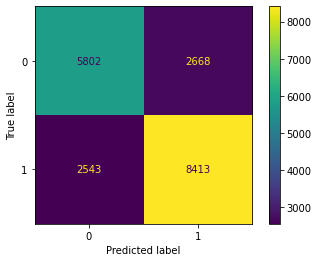

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

disp.plot()
plt.show()

<div class="alert alert-info">
У меня все работает. Я полагаю, из-за более поздней версии sklearn, которая установлена у тебя (матрица ошибок там по другому называется). Если я ее устанавливаю, то у меня перестает работать imblearn 

<div class="alert alert-info">
Как и в прошлый раз модель хуже выявлет случаи, когда авария произошла по вине водителя, однако в этот раз ненамного.  

Модель хуже выявляет случаи, когда авария произошла по вине водителя.

Выведем полноту и точность на графиках. 

In [80]:
df_ = pd.DataFrame({'recall' : [recall_score(y_test, pred)], 'precision':[precision_score(y_test, pred)]})

<AxesSubplot:>

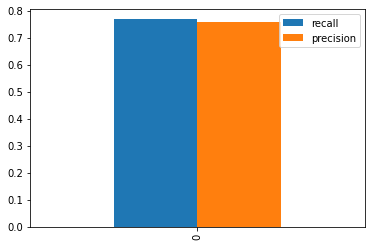

In [81]:
df_.plot.bar()

Перекос в сторону точности очевиден. Полагаю, что просто не все факторы влияющие на аварию могут быть учтены при сборе информации о происшествии.

## Проведите анализ важности факторов ДТП

In [82]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,county_city_location,24.39
1,lighting,10.49
2,vehicle_type,10.14
3,party_sobriety,9.83
4,location_type,9.56
5,vehicle_age,8.75
6,vehicle_transmission,8.22
7,weather_1,7.54
8,road_condition_1,4.51
9,road_surface,4.15


In [83]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_train, y_train, n_repeats=30,
                                random_state=0, n_jobs=-1)

In [84]:
for i, i_1 in zip():
    print(i_1, i)

In [85]:
pd.DataFrame(result['importances_mean'], X_train.columns)

,0
party_sobriety,0.07
intersection,0.00
weather_1,-0.02
road_surface,-0.00
lighting,-0.02
county_city_location,-0.08
location_type,-0.03
road_condition_1,-0.00
vehicle_type,-0.01
vehicle_transmission,-0.02


Очевидно, что основное значение модель придает наличию алкоголя в крови. 

In [86]:
piv = pd.pivot_table(df[['party_sobriety', 'at_fault', 'county_city_location' ]], index='party_sobriety',
               columns='at_fault', aggfunc='count' )
piv.columns = [0, 1]
piv['percent'] = round(piv[1]*100/(piv[0] + piv[1]), 2)
piv

,0,1,percent
party_sobriety,,,
had been drinking,1159,9480,89.11
had not been drinking,38123,37051,49.29
impairment unknown,2465,7639,75.60
not applicable,600,610,50.41


<AxesSubplot:xlabel='party_sobriety'>

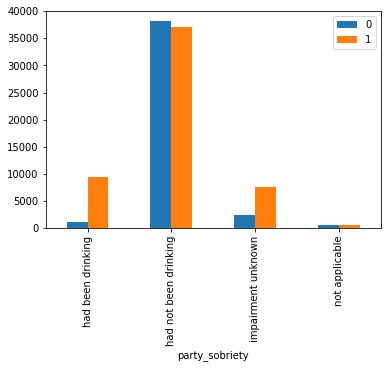

In [87]:
piv[[0, 1]].plot.bar()

In [88]:
piv.loc['had been drinking', 1] / sum(piv[1]) 

0.17305585980284777

Количество аварий, произошедших по вине водителя в состоянии алкогольного последнего составляет 17%, поэтому считаю необходимым рассмотреть вопрос об установке оборудования для проверки водителей на алкогольное опьянение.

## Выводы

Лучшая модель - это случайный лес (300 деревьев, максимальная глубина деревьев 10). Как показал исследовательский анализ данных и применение моделей машинного обучения фактором, наиболее влияет на виновность водителей является алкогольное опьянение последних, поэтому чтобы создать адекватную систему оценки риска при выдаче авто возможно, но только если будет установлено оборудования для проверки водителей на опьянение.  

Кроме того, влияние на варийность оказывает освещенность дороги в темное время сутое, состояние дорожного полотна (сухой, мокрое, покрытое снегом). 